In [1]:
import sys
import os
import pandas as pd
from datetime import datetime
from helper_functions import fetch_granular_data,fetch_and_save_csv_files, csv_to_df
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
%matplotlib inline

donor_data = fetch_granular_data()
donor_data['visit_date'] = donor_data['visit_date'] = pd.to_datetime(donor_data['visit_date'])
donor_data.sort_values(['donor_id','visit_date'], inplace=True)

Removed old data folder: 2024-01-18
downloading online


In [2]:
donor_data['Cohort'] = donor_data.groupby('donor_id')['visit_date'].transform('min').dt.strftime('%Y-%m')
donor_data['Order'] = donor_data.groupby('donor_id').cumcount() + 1


In [29]:
# Step 1: Define bins
bin_edges = [1, 2, 3, 4, 5, 6, 8, 10, 13, donor_data['Order'].max() + 1]
bin_labels = ['1', '2', '3', '4', '5', '6-7','8-9', '10-12','13+']
# bin_edges = [0, 5, 20, 50, 100, 150, 200, 300, donor_data['Order'].max() + 1]  # Assuming 300+ covers the largest orders, adjust if needed
# bin_labels = ['0-5', '6-20', '21-50', '51-100', '101-150', '151-200', '201-300', '301+']

# Step 2: Bin the data with defined bins
bin_result = pd.cut(donor_data['Order'], bins=bin_edges, labels=bin_labels, right=False)

# Add the bin labels as a new column to the donor_data DataFrame for reference
donor_data['Order_Bin_Range'] = bin_result

# Step 3: Display bin ranges with their respective counts
for label in bin_labels:
    print(f"Bin {label}: {donor_data['Order_Bin_Range'].value_counts()[label]} orders")


Bin 1: 2245240 orders
Bin 2: 1075950 orders
Bin 3: 661683 orders
Bin 4: 451004 orders
Bin 5: 326001 orders
Bin 6-7: 437381 orders
Bin 8-9: 276285 orders
Bin 10-12: 258155 orders
Bin 13+: 515128 orders


In [48]:
# Step 1: Extract the year from 'Cohort' and create a new column 'Cohort_Year'
donor_data['Cohort_Year'] = pd.to_datetime(donor_data['Cohort']).dt.year

# Step 2: Adjust the cohort pivot table based on the new 'Order_Bin_Range' and 'Cohort_Year'
cohort_data_binned = donor_data.groupby(['Cohort_Year', 'Order_Bin_Range']).agg(n_donors=('donor_id', 'nunique')).reset_index()
cohort_pivot_binned = cohort_data_binned.pivot_table(index='Cohort_Year', columns='Order_Bin_Range', values='n_donors')
# Filling NaN values with 0 for better visualization
cohort_pivot_binned.fillna(0, inplace=True)

# Display the new pivot table
cohort_size = cohort_pivot_binned.iloc[:,0]
retention_matrix = cohort_pivot_binned.divide(cohort_size,axis=0)

retention_matrix[retention_matrix == 0] = np.nan

retention_matrix



C:\Users\azaid\AppData\Local\Temp\ipykernel_12028\97189309.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_data_binned = donor_data.groupby(['Cohort_Year', 'Order_Bin_Range']).agg(n_donors=('donor_id', 'nunique')).reset_index()


Order_Bin_Range,1,2,3,4,5,6-7,8-9,10-12,13+
Cohort_Year,,,,,,,,,
2012,1.0,0.667780,0.497982,0.388736,0.313035,0.257051,0.181969,0.135272,0.091943
2013,1.0,0.579101,0.387015,0.274189,0.202386,0.153554,0.094991,0.061681,0.035275
2014,1.0,0.552153,0.360899,0.253645,0.185539,0.141555,0.087814,0.059246,0.035470
2015,1.0,0.513802,0.319508,0.214331,0.150592,0.110459,0.064880,0.041200,0.022794
2016,1.0,0.485403,0.289568,0.187412,0.127192,0.090739,0.051405,0.031474,0.015897
2017,1.0,0.462437,0.263810,0.164701,0.110161,0.076811,0.041294,0.024482,0.011969
2018,1.0,0.425343,0.226982,0.137344,0.089615,0.062589,0.033350,0.019591,0.008804
2019,1.0,0.399582,0.214609,0.132509,0.088888,0.062561,0.033904,0.019227,0.007876
2020,1.0,0.437153,0.242478,0.150035,0.098076,0.066805,0.032490,0.015484,0.003737


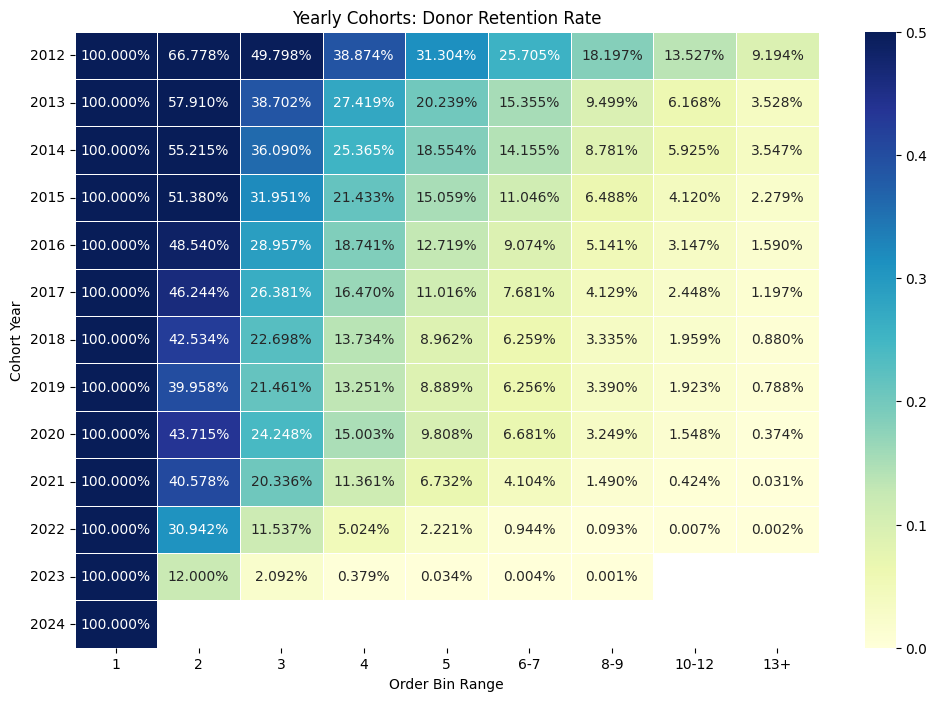

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, 
            annot=True, 
            fmt='.3%', 
            cmap='YlGnBu', 
            vmin=0.0, 
            vmax=0.5,
            linewidths=.5)
plt.title('Yearly Cohorts: Donor Retention Rate')
plt.ylabel('Cohort Year')
plt.xlabel('Order Bin Range')
plt.yticks(rotation=360)

plt.show()

## Observations:
## 1. High Initial Retention: 
    There is a strong initial retention rate in the first bin (1-2 visits), which is 100% for each cohort year by definition.
## 2. Sharp Drop-off: 
    There's a significant drop in retention moving from the first bin to the second (2-3 visits). This suggests that engaging donors beyond their first or second donation is a challenge.
## 3. Decreasing Retention Over Time: 
    As expected, retention rates continue to decrease as the order bin range increases. This indicates fewer donors make it to subsequent donation visits.
## 4. Yearly Retention Decline: 
    Cohorts from earlier years tend to show higher retention rates in subsequent bins compared to more recent years. For instance, the 2012 cohort retains nearly 50% of donors by the 3-4 visit range, while the 2022 cohort retains about 11%.
## 5. Long-term Retention: 
    Long-term retention (10-12 visits and 13+ visits) is quite low across all cohorts, which is common in many organizations.